In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import nglview as ngl
%matplotlib inline

## Read in the MD trajectory

Below we read in the production simulation trajectory using the topology available in the PDB file of the starting structure.

In [2]:
traj = md.load('butane_sim.dcd', top='butane.pdb')
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


## Analyzing the C-C-C-C torsion

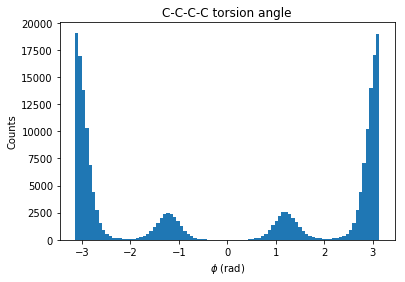

200000.0


In [3]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('C-C-C-C torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

print(np.sum(phicounts))

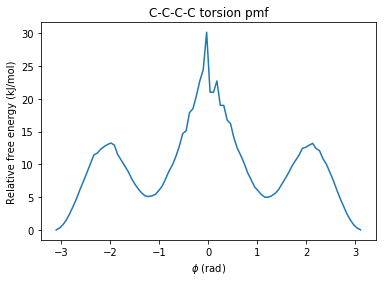

In [4]:
kB = 8.31446/1000 # Boltzmann constant in kcal/mol
Temp = 298.15 # simulation temperature in K
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

The pmf looks a bit jagged at the _cis_ peak, so let's try to smooth it out using the LOWESS algorithm (try out some different values of the frac parameter):

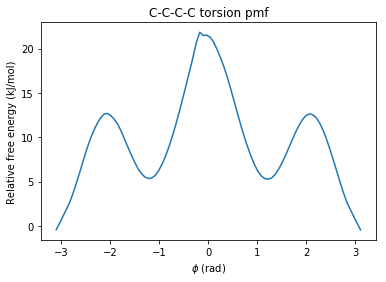

In [6]:
pmf_smoothed = sm.nonparametric.lowess(pmf, bincenters, frac=0.1)
plt.plot(pmf_smoothed[:,0], pmf_smoothed[:,1])
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

## Analyzing the C-C-C bond angle

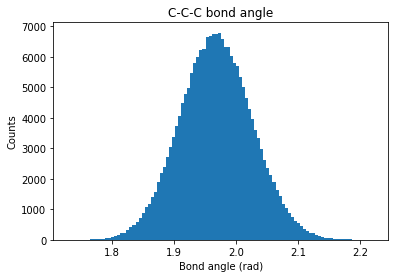

In [7]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

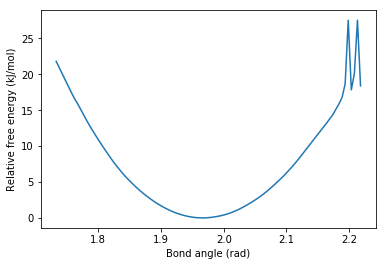

In [8]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2

pmf_smoothed = sm.nonparametric.lowess(pmf, bincenters, frac=0.1)
pmf_s = pmf_smoothed[:,1] - np.min(pmf_smoothed[:,1])

plt.plot(bincenters, pmf_s)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

Once again, the pmf gets a bit "lumpy" beyond 15 kJ/mol, so let's truncate our plot to only include bond angles with free energies less than that:

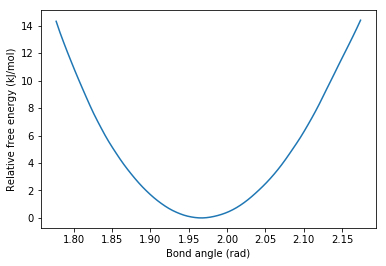

In [9]:
plt.plot(bincenters[pmf_s < 15], pmf_s[pmf_s < 15])
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

Hey...it's another harmonic potential!

## Analyzing a C-H bond length

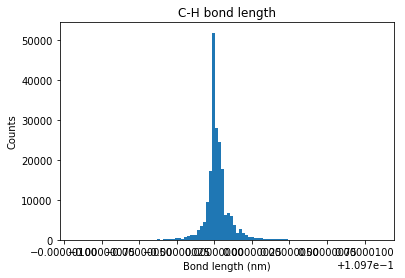

In [10]:
bond_indices = [0, 1] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

The C-H bond length does not behave at all like something subject to a harmonic potential.  So what's going on?  Remember that in this simulation we have "frozen" all of the covalent bonds involving H atoms so that we can use a 2 fs time step.  Therefore only the non-H atoms undergo true dynamics; the positions of the H atoms are calculated after each time step using an interative algorithm (SHAKE).  For more information, check out: https://en.wikipedia.org/wiki/Constraint_(computational_chemistry)#The_SHAKE_algorithm

## Trajectory visualization

In [11]:
visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(count=200000)